# Deepweeds - MobileNetv3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

tf.__version__

2025-06-29 01:41:26.688235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 01:41:26.688360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 01:41:26.819272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

# Configurations

In [2]:
INFERENCE_DEVICE = 'GPU:0' if len(tf.config.list_physical_devices('GPU')) else 'CPU:0'

################################
###### Configurations #########
##############################
seed = 999
SEED = seed
USE_DETERMINISTIC = True
K_FOLD_INDEX = 3
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME=f"MobileNetV3Small_KF{K_FOLD_INDEX+1}.keras"
IMG_SIZE=(224,224,3)

## Training Configurations
TRAIN_BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 16 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-7 ## Minimum Learning Rate for ReduceLROnPlateau Callback
##
USE_WARMUP = False
WARMUP_EPOCHS = 5
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCHS
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.3

##### Base Model Freezing Part
INIT_LR2 = 2e-6 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-4 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau

#### -- Optimizer
USE_ADAMW = '2.15' in tf.__version__
#########################################
isKaggle = 'kaggle' in os.getcwd()

if isKaggle:
    DATASET_PATH = "/kaggle/input/deepweeds"
    IMAGE_DATASET_PATH = "/kaggle/input/deepweeds/images" ## For Kaggle
    DATASET_OUTPUT_PATH = "/kaggle/working/deepweeds_9c" ## For Kaggle
else:
    try:
        DATASET_PATH = reganmaharjan_deepweeds_path
        DATASET_OUTPUT_PATH = '/content/dataset_9c' ## For GoogleColab
        IMAGE_DATASET_PATH = reganmaharjan_deepweeds_path + '/images' ## For GoogleColab
    except:
        DATASET_PATH = ''
        IMAGE_DATASET_PATH = '' ## Assign The Image Path
        DATASET_OUTPUT_PATH = '' ## Assign The path where the Images are to ogranized for Data Generator from Directory


isTPU = False
fixDatasetBatch = False ## if True: duplicates files randomly such that each batch contains same no.of files - Required when isTPU=True.

In [3]:
print("Tensorflow version " + tf.__version__)
if tf.config.list_logical_devices('TPU'):
    if isKaggle:
        # On TPU VMs use this line instead:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  ## if kaggle
    else:        
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver() ## if colab

    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    #---------
    strategy = tf.distribute.TPUStrategy(resolver)
    print('TPU available')
    isTPU = True
else: ### If GPU or CPU
    if tf.config.list_logical_devices('GPU'): 
        print('GPU available')
    else:
        print("Only CPU available")
       
    # For testing without a TPU use this line instead: 
    # strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    strategy = tf.distribute.MirroredStrategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)
if isTPU:
    USE_ADAMW = False
    LR_REDUCTION_PATIENCE = 5
    ES_PATIENCE = 27
    print("Use ADAM with TPU")

Tensorflow version 2.15.0
GPU available
REPLICAS:  1


In [4]:
def seedEverything(seed=42, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    tf.keras.utils.set_random_seed(seed)
    
    if deterministic:
        tf.config.experimental.enable_op_determinism()
        
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED, USE_DETERMINISTIC)
tf.config.set_soft_device_placement(True)

In [5]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [6]:
try:
    data_info = pd.read_csv(f"{DATASET_PATH}/labels.csv") ## For Kaggle
except:
    data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [7]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [8]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [9]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 4 out of 5 folds
-------------------------------------------------



In [11]:
## Using Folds Used in The DeepWeeds Paper
try:
    train_data = pd.read_csv(f'{DATASET_PATH}/train_subset{K_FOLD_INDEX}.csv')
    valid_data = pd.read_csv(f'{DATASET_PATH}/val_subset{K_FOLD_INDEX}.csv')
    test_data = pd.read_csv(f'{DATASET_PATH}/test_subset{K_FOLD_INDEX}.csv')

except:
    train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
    valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
    test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab

train_data.rename(columns={"Label":"label"}, inplace=True)
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  614  637  605  644  610  5463 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  213  202  215  203  1822 	Total: (3503, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  204  212  202  215  203  1821 	Total: (3500, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0, oversampling_labels=[]):
    indices=[]
    if fixDatasetBatch or isTPU:
        batch = TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync
        size = data_info.shape[0]
        remainder = size % batch
        residue = batch - remainder
        rng = np.arange(size)
        np.random.shuffle(rng)
        indices = rng[:residue]
        
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)
            elif index in indices:
                sample_filename = os.path.join(target_path, f"last_batch_fix_{index}-"+filename)
                shutil.copy(source, sample_filename)
                
            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import math

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.0 if math.isnan(v) else v for v in history['accuracy']]
    val_acc = [0.0 if math.isnan(v) else v for v in history['val_accuracy']]
    loss = [0.0 if math.isnan(v) else v for v in history['loss']]
    val_loss = [0.0 if math.isnan(v) else v for v in history['val_loss']]
    
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [14]:
if oversampling:
    print("Oversampling training set",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

input_dir = IMAGE_DATASET_PATH
base_dir = DATASET_OUTPUT_PATH

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

with strategy.scope(): 
    if isTPU:  
        train_generator = train_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        validation_generator = validation_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        test_generator = test_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        
    train_generator = train_generator.prefetch(tf.data.AUTOTUNE)
    validation_generator = validation_generator.prefetch(tf.data.AUTOTUNE)
    test_generator = test_generator.prefetch(tf.data.AUTOTUNE)     

Found 10506 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.
Found 3500 files belonging to 9 classes.


# Sample Images

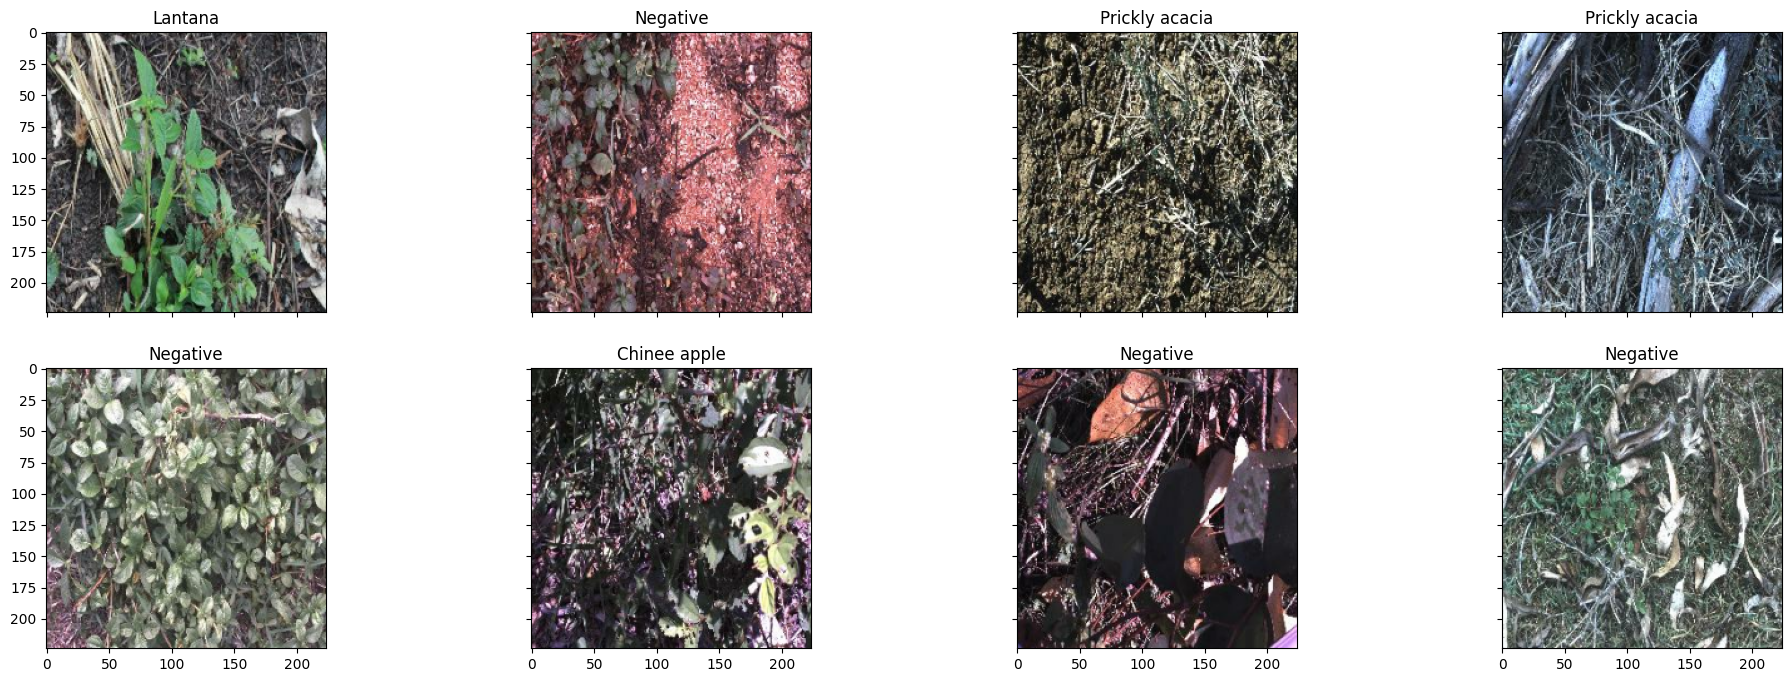

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    augs = [] if isTPU else [layers.RandomRotation(0.5, seed=seed, name='RR_Rot'), 
                            layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
                            layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),] ## can't run with TPU
    
    aug_model = keras.Sequential([
        layers.Input(IMG_SIZE),
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        *augs,
        layers.GaussianNoise(0.01, seed=SEED, name='RR_GNoise'),
        # layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')
    aug_model.summary()
    
    return aug_model


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('conv' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    FCLayer = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-FCLayer")
    
    return base_model , FCLayer

def buildModel(IMG_SIZE, fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, FCLayer = MobilenetV3Base(IMG_SIZE)
    base_model.trainable = True
    FCLayer.trainable = True
    FCLayer.summary()
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.3, seed=SEED)(x) 
    
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = FCLayer(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
with strategy.scope():
    model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Model: "MobileNet-FCLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 576)]       0         
                                                                 
 Conv_2 (Conv2D)             (None, 1, 1, 1024)        590848    
                                                                 
Total params: 590848 (2.25 MB)
Trainable params: 590848 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Base Model: MobilenetV3small_base_
228
Model: "augment_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RR_Bright (RandomBrightnes  (None, 224, 224, 3)       0         
 s)                                                              
               

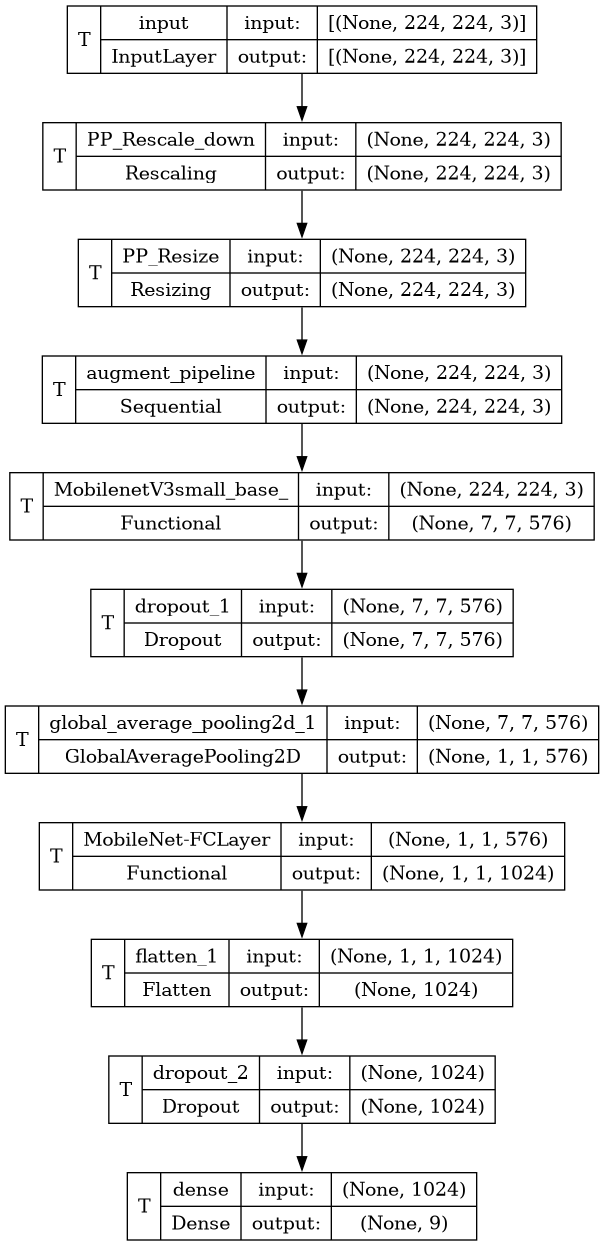

In [20]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import Adam, AdamW

checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor=ES_MONITOR)
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1, clipnorm=1.0) if not USE_ADAMW else AdamW(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

    def createWarmUpScheduler(epochs=5, inc_rate=0.5, init_lr=2e-6, final_lr=2e-5):
        def scheduler(e, lr):
            if e < epochs:
                new_lr =  lr + (lr * inc_rate)
                return new_lr if new_lr < final_lr else final_lr
            elif e == epochs:
                return final_lr
            else:
                return lr

        return scheduler
        
    warmup = keras.callbacks.LearningRateScheduler(createWarmUpScheduler(WARMUP_EPOCHS, WARMUP_INCREMENT_RATE, WARMUP_INIT_LR, INIT_LR1))

    callbacks = [checkpoint, early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])
    print(len(callbacks))

print(model.optimizer.get_config())

3
{'name': 'AdamW', 'weight_decay': 0.05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0002, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-29 01:44:12.883592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751161458.956689      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 60s 85ms/step - loss: 0.2508 - accuracy: 0.5351 - val_loss: 0.1105 - val_accuracy: 0.7165 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 25s 74ms/step - loss: 0.1372 - accuracy: 0.6721 - val_loss: 0.0835 - val_accuracy: 0.7739 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 24s 74ms/step - loss: 0.1128 - accuracy: 0.7141 - val_loss: 0.0684 - val_accuracy: 0.8124 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 24s 73ms/step - loss: 0.0941 - accuracy: 0.7519 - val_loss: 0.0621 - val_accuracy: 0.8336 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 24s 73ms/step - loss: 0.0846 - accuracy: 0.7740 - val_loss: 0.0501 - val_accuracy: 0.8613 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 24s 73ms/step - loss: 0.0756 - accuracy: 0.7950 - val_loss: 0.0491 - val_accuracy: 0.8610 - lr: 2.0000e-04
Epoch 7/300
329/329 [===================

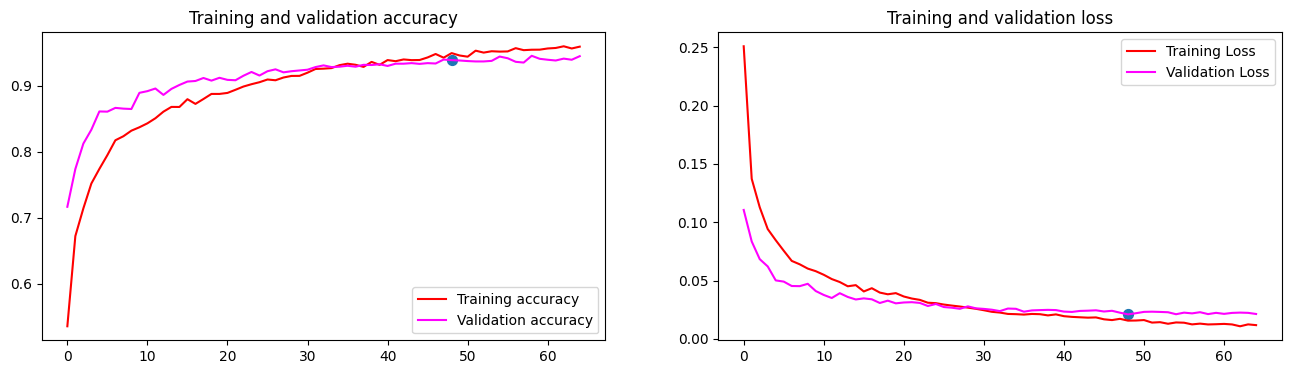

CPU times: user 52min 31s, sys: 4min 9s, total: 56min 40s
Wall time: 26min 20s


In [22]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 24ms/step - loss: 0.0059 - accuracy: 0.9784
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.96108   0.94970   0.95536       676
       Lantana    0.97953   0.97492   0.97722       638
   Parkinsonia    0.96395   0.99354   0.97852       619
    Parthenium    0.99150   0.94951   0.97005       614
Prickly acacia    0.96429   0.97488   0.96956       637
   Rubber vine    0.98841   0.98678   0.98759       605
     Siam weed    0.99840   0.97050   0.98425       644
    Snake weed    0.94814   0.95902   0.95355       610
      Negative    0.98396   0.98810   0.98603      5463

      accuracy                        0.97925     10506
     macro avg    0.97547   0.97188   0.97357     10506
  weighted avg    0.97935   0.97925   0.97924     10506


                False Positive Rate  Accuracy
Chinee apple               0.002645  0.949704
Lantana                    0.001317  0.974922
Parkinsonia                0.002326  0.993538
Parthenium                 0.000505  0.949511
Prickly acacia    

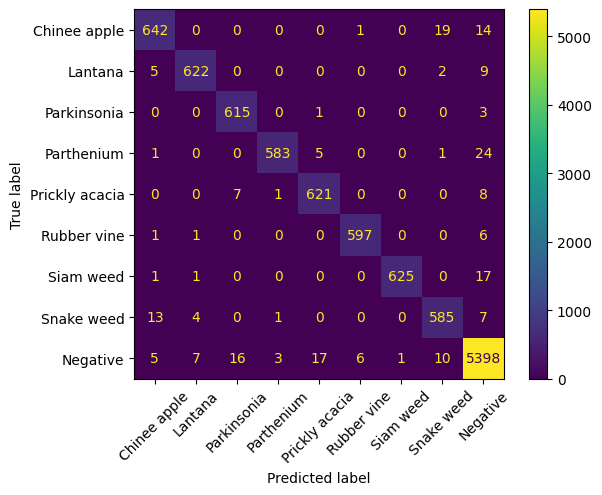


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 24ms/step - loss: 0.0231 - accuracy: 0.9318
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.86854   0.82222   0.84475       225
       Lantana    0.94737   0.92958   0.93839       213
   Parkinsonia    0.93056   0.97573   0.95261       206
    Parthenium    0.97838   0.88725   0.93059       204
Prickly acacia    0.93023   0.93897   0.93458       213
   Rubber vine    0.94175   0.96040   0.95098       202
     Siam weed    0.95000   0.88372   0.91566       215
    Snake weed    0.82692   0.84729   0.83698       203
      Negative    0.95192   0.96707   0.95943      1822

      accuracy                        0.93720      3503
     macro avg    0.92507   0.91247   0.91822      3503
  weighted avg    0.93730   0.93720   0.93693      3503


                False Positive Rate  Accuracy
Chinee apple               0.008542  0.822222
Lantana                    0.003343  0.929577
Parkinsonia                0.004550  0.975728
Parthenium                 0.001212  0.887255
Prickly acacia    

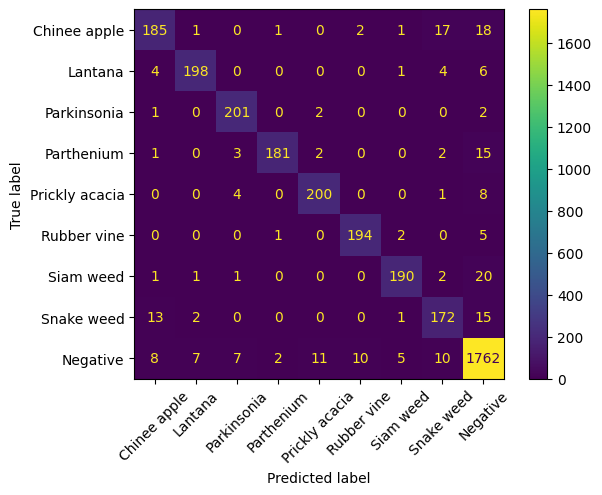


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 0.4757 - accuracy: 0.5049
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.17518   0.10667   0.13260       225
       Lantana    0.23611   0.08019   0.11972       212
   Parkinsonia    0.43182   0.09223   0.15200       206
    Parthenium    0.30952   0.06373   0.10569       204
Prickly acacia    0.30303   0.04717   0.08163       212
   Rubber vine    0.38983   0.11386   0.17625       202
     Siam weed    0.18182   0.02791   0.04839       215
    Snake weed    0.18478   0.08374   0.11525       203
      Negative    0.54819   0.89951   0.68122      1821

      accuracy                        0.50486      3500
     macro avg    0.30670   0.16833   0.17919      3500
  weighted avg    0.41698   0.50486   0.41009      3500


                False Positive Rate  Accuracy
Chinee apple               0.034504  0.106667
Lantana                    0.016727  0.080189
Parkinsonia                0.007590  0.092233
Parthenium                 0.008799  0.063725
Prickly acacia    

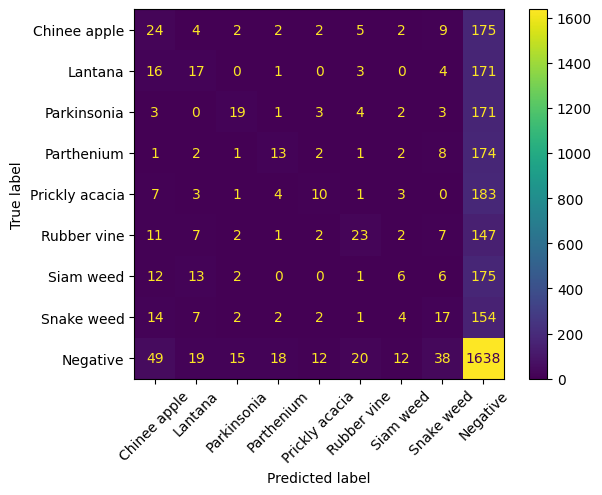

In [23]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Freezing Base Model

In [24]:
with strategy.scope():
    for layer in model.layers:
        if 'base' in layer.name.lower():
            print("Freezing layer", layer.name, layer.trainable)
            layer.trainable = False

Freezing layer MobilenetV3small_base_ True


# Evaluations #1.1b

Test After Freezing
Validation Set Stats
model.evaluate
110/110 [==============================] - 3s 24ms/step - loss: 0.0231 - accuracy: 0.9323
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93333   0.80889   0.86667       225
       Lantana    0.97030   0.92019   0.94458       213
   Parkinsonia    0.93023   0.97087   0.95012       206
    Parthenium    0.95455   0.92647   0.94030       204
Prickly acacia    0.88938   0.94366   0.91572       213
   Rubber vine    0.95960   0.94059   0.95000       202
     Siam weed    0.98964   0.88837   0.93627       215
    Snake weed    0.88945   0.87192   0.88060       203
      Negative    0.94672   0.97530   0.96080      1822

      accuracy                        0.94291      3503
     macro avg    0.94035   0.91625   0.92723      3503
  weighted avg    0.94335   0.94291   0.94243      3503


                False Positive Rate  Accuracy
Chinee apple               0.003966  0.808889
Lantana                    0.001824  0.920188
Parkinsonia                0.004550  0.970874
Parthenium                 0.002728  0.926471
Prickly acacia    

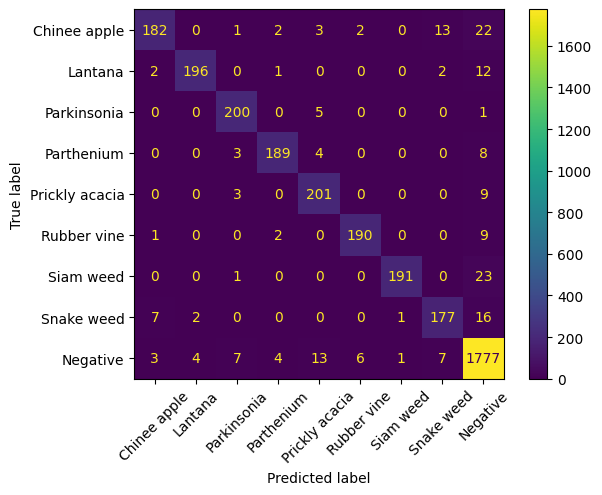

Test Set Stats
model.evaluate
110/110 [==============================] - 4s 30ms/step - loss: 0.4757 - accuracy: 0.5049
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90610   0.85778   0.88128       225
       Lantana    0.97382   0.87736   0.92308       212
   Parkinsonia    0.94231   0.95146   0.94686       206
    Parthenium    0.96569   0.96569   0.96569       204
Prickly acacia    0.90323   0.92453   0.91375       212
   Rubber vine    0.94872   0.91584   0.93199       202
     Siam weed    0.98969   0.89302   0.93888       215
    Snake weed    0.82326   0.87192   0.84689       203
      Negative    0.95115   0.97309   0.96200      1821

      accuracy                        0.94114      3500
     macro avg    0.93377   0.91452   0.92338      3500
  weighted avg    0.94186   0.94114   0.94102      3500


                False Positive Rate  Accuracy
Chinee apple               0.006107  0.857778
Lantana                    0.001521  0.877358
Parkinsonia                0.003643  0.951456
Parthenium                 0.002124  0.965686
Prickly acacia    

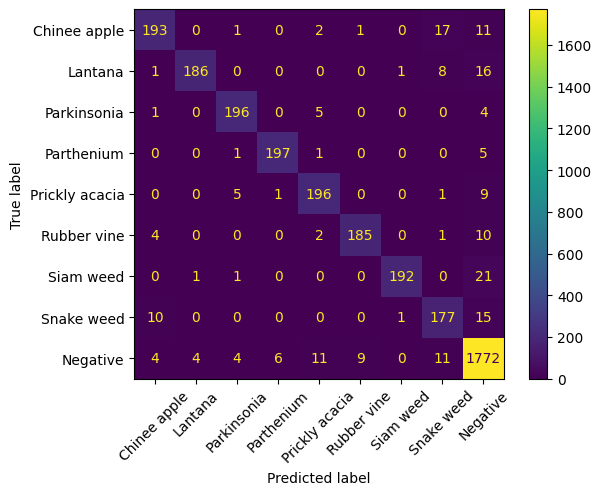

In [25]:
## Test After Freezing
print("Test After Freezing")
print("Validation Set Stats")        
a, b = eval_model(model, validation_generator)

print("Test Set Stats")   
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81224   0.88444   0.84681       225
       Lantana    0.84322   0.93868   0.88839       212
   Parkinsonia    0.94231   0.95146   0.94686       206
    Parthenium    0.96552   0.96078   0.96314       204
Prickly acacia    0.80159   0.95283   0.87069       212
   Rubber vine    0.94359   0.91089   0.92695       202
     Siam weed    0.98462   0.89302   0.93659       215
    Snake weed    0.82326   0.87192   0.84689       203
      Negative    0.96573   0.92861   0.94681      1821

      accuracy                        0.92457      3500
     macro avg    0.89801   0.92140   0.90813      3500
  weighted avg    0.92873   0.92457   0.92562      3500


                False Positive Rate  Accuracy
Chinee apple               0.014046  0.884444
Lantana                    0.011253  0.938679
Parkinsonia                0.003643  0.951456
Parthenium                 0.002124  0.960784
Prickly acacia    

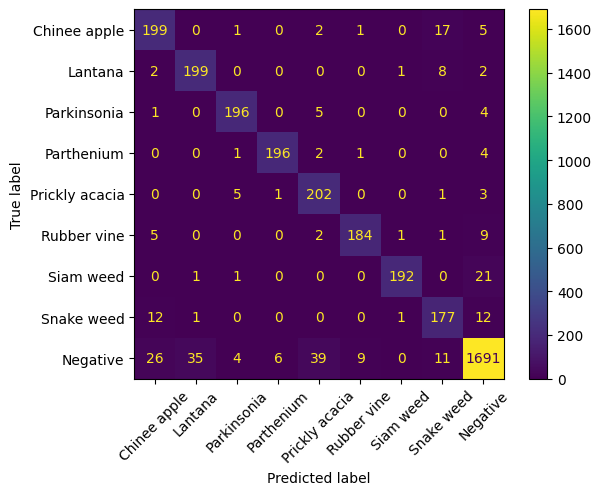

In [26]:
printStats(a,b,0.11)

# Trial 2

In [27]:
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=INIT_LR2,  weight_decay=W_DECAY2, clipnorm=2.0) if not USE_ADAMW else AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=ES_MONITOR, factor=LR_REDUCTION_FACTOR, patience=ES_PATIENCE, verbose=1, min_lr=MIN_LR2)


print(model.optimizer.get_config())

{'name': 'AdamW', 'weight_decay': 0.0005, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 2e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-29 02:15:08.124397: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 17s 38ms/step - loss: 0.0447 - accuracy: 0.8649 - val_loss: 0.0208 - val_accuracy: 0.9429 - lr: 2.0000e-06
Epoch 2/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0423 - accuracy: 0.8742 - val_loss: 0.0205 - val_accuracy: 0.9440 - lr: 2.0000e-06
Epoch 3/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0398 - accuracy: 0.8818 - val_loss: 0.0203 - val_accuracy: 0.9443 - lr: 2.0000e-06
Epoch 4/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0386 - accuracy: 0.8814 - val_loss: 0.0201 - val_accuracy: 0.9443 - lr: 2.0000e-06
Epoch 5/300
329/329 [==============================] - 12s 37ms/step - loss: 0.0372 - accuracy: 0.8876 - val_loss: 0.0201 - val_accuracy: 0.9449 - lr: 2.0000e-06
Epoch 6/300
329/329 [==============================] - 12s 35ms/step - loss: 0.0354 - accuracy: 0.8968 - val_loss: 0.0201 - val_accuracy: 0.9435 - lr: 2.0000e-06
Epoch 7/300
329/329 [===================

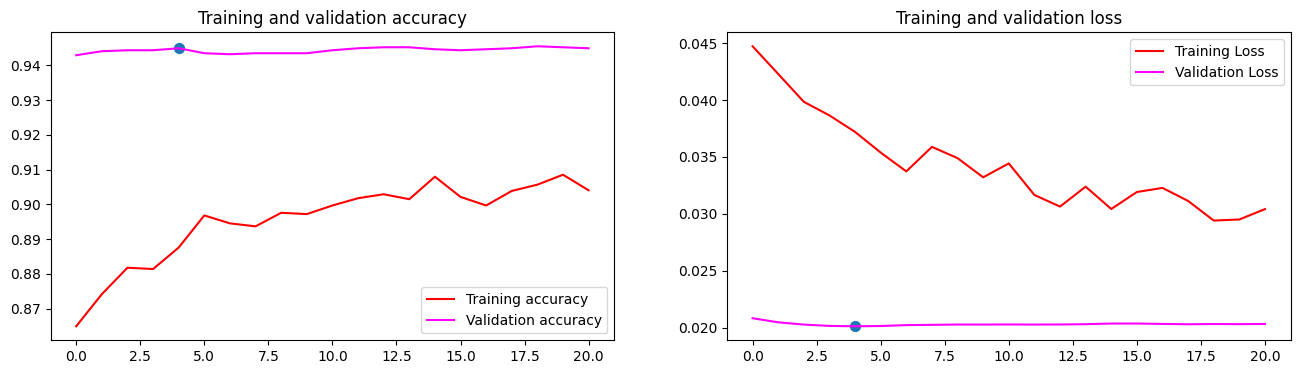

In [28]:
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Checkpoint")
model.save("2-"+MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)


# Accuracy / Loss Plots

Total Epochs: range(0, 86)


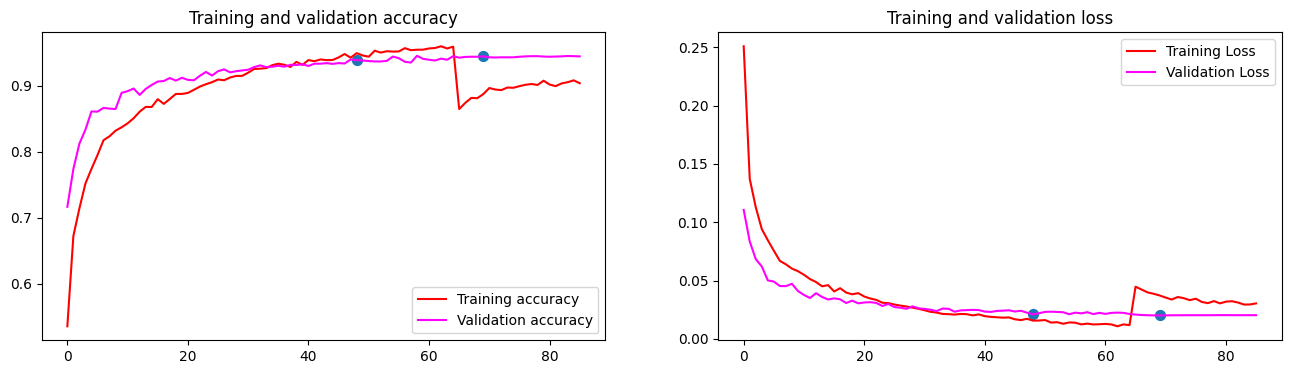

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 65)


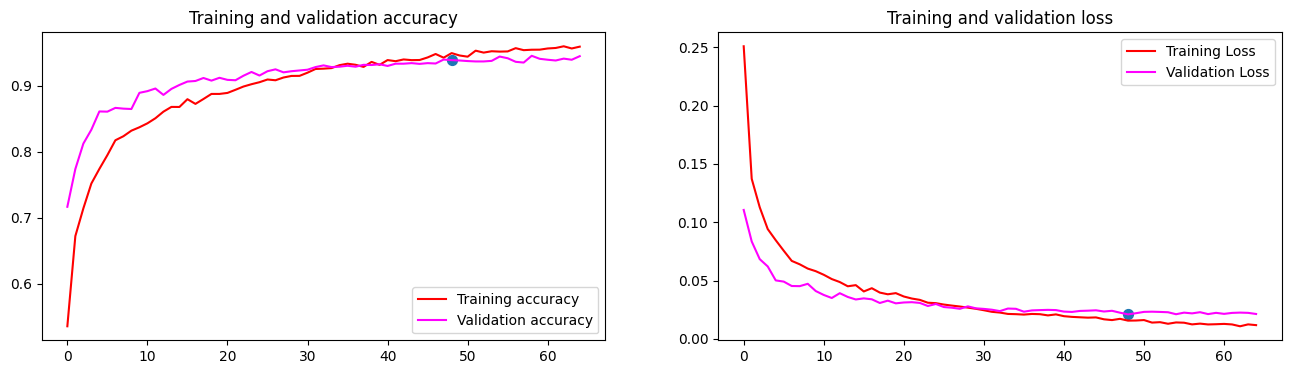

Total Epochs: range(0, 21)


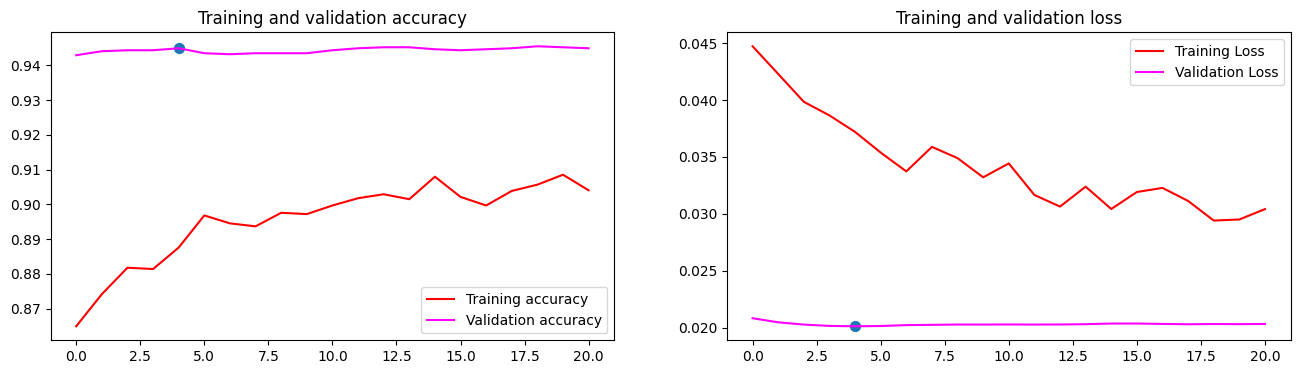

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 7s 21ms/step - loss: 0.0036 - accuracy: 0.9863
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.98469   0.95118   0.96764       676
       Lantana    0.99209   0.98276   0.98740       638
   Parkinsonia    0.98880   0.99838   0.99357       619
    Parthenium    0.99158   0.95928   0.97517       614
Prickly acacia    0.96330   0.98901   0.97599       637
   Rubber vine    0.97886   0.99504   0.98689       605
     Siam weed    0.99224   0.99224   0.99224       644
    Snake weed    0.94770   0.98033   0.96374       610
      Negative    0.99230   0.99140   0.99185      5463

      accuracy                        0.98629     10506
     macro avg    0.98128   0.98218   0.98161     10506
  weighted avg    0.98643   0.98629   0.98629     10506


                False Positive Rate  Accuracy
Chinee apple               0.001017  0.951183
Lantana                    0.000507  0.982759
Parkinsonia                0.000708  0.998384
Parthenium                 0.000505  0.959283
Prickly acacia    

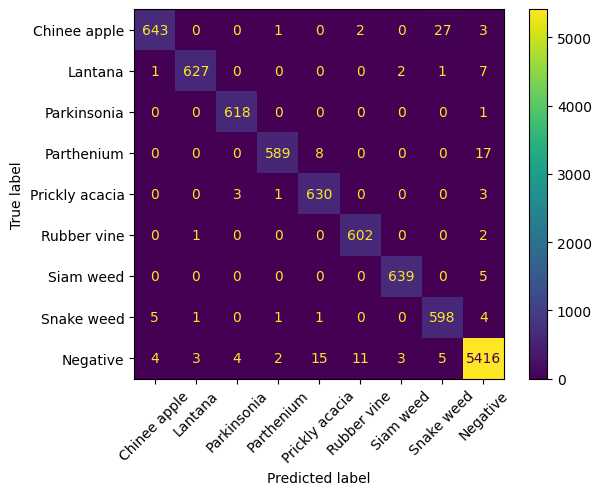


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 21ms/step - loss: 0.0201 - accuracy: 0.9449
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93401   0.81778   0.87204       225
       Lantana    0.95610   0.92019   0.93780       213
   Parkinsonia    0.94313   0.96602   0.95444       206
    Parthenium    0.97340   0.89706   0.93367       204
Prickly acacia    0.89333   0.94366   0.91781       213
   Rubber vine    0.92857   0.96535   0.94660       202
     Siam weed    0.95755   0.94419   0.95082       215
    Snake weed    0.88293   0.89163   0.88725       203
      Negative    0.95568   0.97036   0.96296      1822

      accuracy                        0.94490      3503
     macro avg    0.93608   0.92403   0.92927      3503
  weighted avg    0.94515   0.94490   0.94456      3503


                False Positive Rate  Accuracy
Chinee apple               0.003966  0.817778
Lantana                    0.002736  0.920188
Parkinsonia                0.003640  0.966019
Parthenium                 0.001516  0.897059
Prickly acacia    

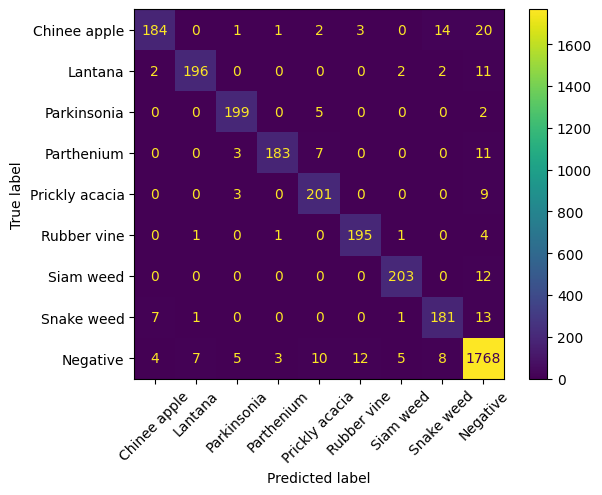


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 21ms/step - loss: 0.0233 - accuracy: 0.9423
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.92500   0.82222   0.87059       225
       Lantana    0.94975   0.89151   0.91971       212
   Parkinsonia    0.95122   0.94660   0.94891       206
    Parthenium    0.98446   0.93137   0.95718       204
Prickly acacia    0.90278   0.91981   0.91121       212
   Rubber vine    0.94118   0.95050   0.94581       202
     Siam weed    0.95305   0.94419   0.94860       215
    Snake weed    0.78723   0.91133   0.84475       203
      Negative    0.96131   0.96870   0.96499      1821

      accuracy                        0.94229      3500
     macro avg    0.92844   0.92069   0.92353      3500
  weighted avg    0.94372   0.94229   0.94243      3500


                False Positive Rate  Accuracy
Chinee apple               0.004580  0.822222
Lantana                    0.003041  0.891509
Parkinsonia                0.003036  0.946602
Parthenium                 0.000910  0.931373
Prickly acacia    

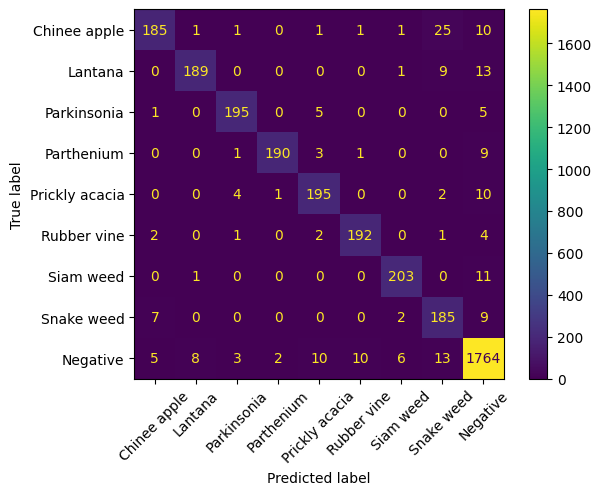

In [31]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83333   0.84444   0.83885       225
       Lantana    0.79365   0.94340   0.86207       212
   Parkinsonia    0.95122   0.94660   0.94891       206
    Parthenium    0.98438   0.92647   0.95455       204
Prickly acacia    0.81377   0.94811   0.87582       212
   Rubber vine    0.93627   0.94554   0.94089       202
     Siam weed    0.94860   0.94419   0.94639       215
    Snake weed    0.78390   0.91133   0.84282       203
      Negative    0.97329   0.92037   0.94609      1821

      accuracy                        0.92286      3500
     macro avg    0.89093   0.92561   0.90626      3500
  weighted avg    0.92846   0.92286   0.92424      3500


                False Positive Rate  Accuracy
Chinee apple               0.011603  0.844444
Lantana                    0.015815  0.943396
Parkinsonia                0.003036  0.946602
Parthenium                 0.000910  0.926471
Prickly acacia    

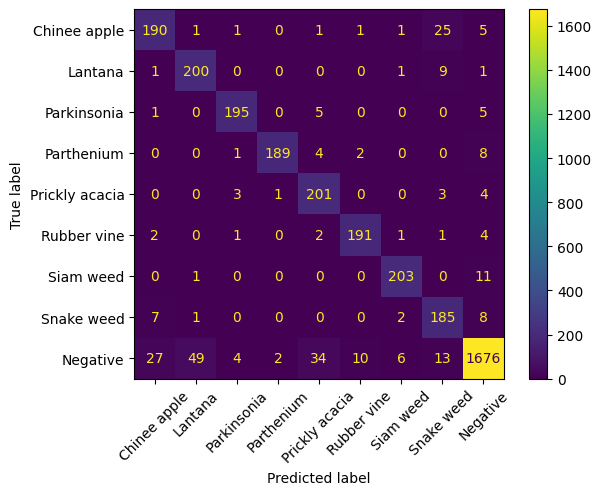

In [32]:
printStats(a,b,0.11)

## Clear Files

In [33]:
shutil.rmtree(base_dir)